# A/B Testing

## Exploring Hypothesis Testing and Test Statistic Estimation

In [26]:
import numpy as np
import matplotlib.pyplot as plt

### Hypothesis Test

For an A/B test, we'll assume the null hypothesis to be such that: **the test statistic is impervious to change**. In other words, *the test statistic is not affected by the redesign*. For this scenario, we'll take the fractional difference between Group A (40%) and Group B (60%). See the image below of how the data is split between the two groups, and the click-through rate (CTR) for each.

<img src="amex_ABtestexample.png" width="200" height="600">

Defining some helpful functions:

In [2]:
def permutation_sample(data_1, data_2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data_1, data_2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data_1)]
    perm_sample_2 = permuted_data[len(data_1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def p_value(exp, obs):
    """Calculate the p_value (the probability of getting the observed 
    value assuming the null hypothesis is true)"""
    
    return (np.sum(exp >= obs)) / len(exp)

Let's define the test statistic for the hypothesis test (fractional difference between groups):

In [3]:
def diff_frac(data_A, data_B):
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return frac_B - frac_A

Generating an array of 1's and 0's (where the 1's define a click-through), we can create 10,000 bootstrap replicates by permutating the data under the null hypothesis. Finally, we'll calculate the observed fractional difference (0.2 or 20%) and generate the p_value.

In [99]:
clickthrough_A = np.random.permutation(np.array(30*[0] + 20*[1]))
clickthrough_B = np.random.permutation(np.array(20*[0] + 30*[1]))

In [100]:
diff_frac_exp = draw_perm_reps(clickthrough_A,clickthrough_B,
                               func = diff_frac, size = 10000)

In [101]:
diff_frac_obs = diff_frac(clickthrough_A,clickthrough_B)

In [102]:
p = p_value(diff_frac_exp, diff_frac_obs)
alpha = 0.05

In [103]:
print('p_value =', p)
print('alpha =', alpha)

p_value = 0.0362
alpha = 0.05


Assuming an alpha (threshold param) as the typical 0.05, we can reject the null hypothesis (as p is less than alpha) that the test statistic (fractional difference) is impervious to change, and thus conclude that there is statistical signficance.

We must note that even though our p_value was close to our designated alpha value, we took 10,000 bootstrap replicates to obtain said p_value, and thus we can feel confident about the probability of obtaining the observed value given the null hypothesis. Of course, if we increased the bootstrap simulation size, we would obtain a larger p_value. Conversely, if we had a larger data set (assuming similar clickthrough rate), we'd expect a smaller p_value. 

### Test Statistic Estimation

In addition to the hypothesis test, we can also estimate the uplift (or percent change between Group A and B). We can do this by creating 1 million bootstrap replicates and computing the 95% confidence interval. 

In [61]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def frac_any(data):
    """Generate fraction of data (equal to 1)"""
    return np.sum(data) / len(data)

def frac_change(data_A, data_B):
    """Generate fractional change"""
    frac_A = np.sum(data_A) / len(data_A)
    frac_B = np.sum(data_B) / len(data_B)
    return (frac_B - frac_A) / frac_A

Let's re-define the clickthrough data by simply adding more data. We'll do this so that we can simulate a tighter confidence interval. Note that this was simply done for the sake of this example.

In [ ]:
clickthrough_A = np.random.permutation(np.array(30000*[0] + 20000*[1]))
clickthrough_B = np.random.permutation(np.array(20000*[0] + 30000*[1]))

In [94]:
uplift_obs = frac_change(clickthrough_A,clickthrough_B)

In [93]:
bs_replicates_Group_A = draw_bs_reps(clickthrough_A, frac_any, 10000)
bs_replicates_Group_B = draw_bs_reps(clickthrough_B, frac_any, 10000)

In [104]:
bs_diff_replicates = ((bs_replicates_Group_B - bs_replicates_Group_A) / 
                      bs_replicates_Group_A)

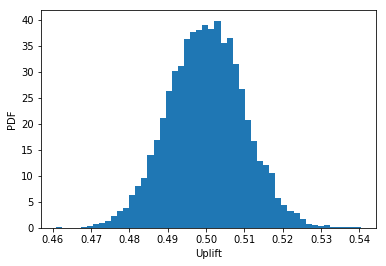

In [96]:
plt.hist(bs_diff_replicates, bins=50, normed = True)
plt.xlabel("Uplift")
plt.ylabel('PDF')
plt.show()

In [97]:
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

In [98]:
# Print the results
print('Uplift =', uplift_obs)
print('95% confidence interval =', conf_int)

Uplift = 0.5
95% confidence interval = [ 0.48063858  0.51933278]


We can note the normal distribution obtained by taking 10,000 bootstrap replicates of the uplift statistic. The interval is tight around the uplift statistic, with a 95% chance the uplift being as little as about 48% to at most 52%. 

The confidence interval is helpful here for an A/B test if one designates a particular threshold for the uplift to be met. For example, if the team designates that the redesign of a particular webpage must garner an uplift of atleast 45%, then one can say with 95% certainty that this A/B test produced results that obtained a reasonable uplift. 

If the threshold is above the interval, then one must consider collecting more data for the A/B test and/or creating a new redesign.

*Reference: Some functions were heavily influenced from Datacamp, a data science online learning environment. All code is free and open-source. Thanks Datacamp!*